In [1]:
from copy import deepcopy
from pathlib import Path
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import tifffile
import yaml

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [45]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [11]:
mushroom_dir = Path('/data/estorrs/mushroom/data/runs/example_run/mushroom_50res')

# Analyses from output.pkl file

## Basic plotting

In [12]:
filepath = mushroom_dir / 'outputs.pkl'
outputs = pickle.load(open(filepath, 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [58]:
# grabbing the level 1 xenium clusters
# volume is of shape (n_sections, height, width)
level = 1
nbhds = outputs['dtype_to_clusters']['xenium'][level]
nbhds.shape

(2, 316, 284)

In [59]:
# each pixel has an integer label corresponding to a neighborhood
np.unique(nbhds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

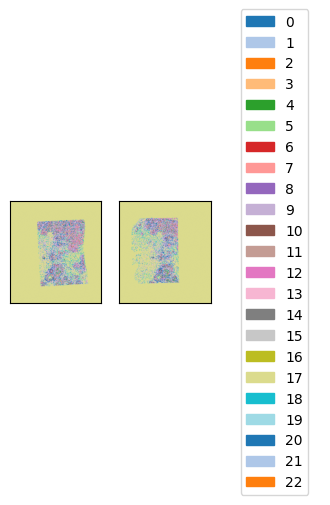

In [60]:
# we can plot the sections
vis_utils.display_clusters(nbhds)

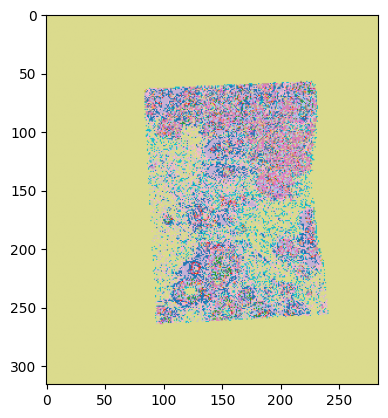

In [61]:
# or we can generate an rgb image directly for a section
rgb = vis_utils.display_labeled_as_rgb(nbhds[0])
plt.imshow(rgb)

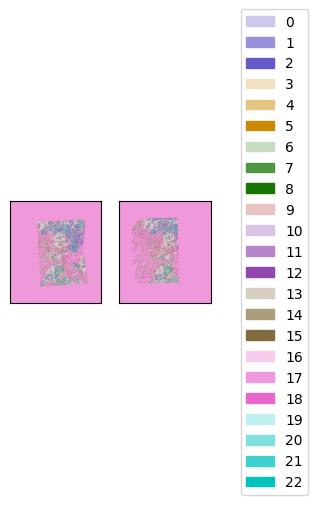

In [63]:
# we can also plot it with the hierarchical neighborhood colormap
vis_utils.display_clusters(nbhds, label_to_hierarchy=outputs['dtype_to_cluster_to_agg']['xenium'][level])

## Assigning points to a neighborhood

We can also assign points (i.e. cells, visium spots, etc.) to a neighborhood.

To do so, we need to know the target resolution of the mushroom model, as well as the resolution of the input data. If you don't already know, you can grab this information from the config.yaml file in the mushroom directory.

In the case of this sample, the mushroom target resolution was 50 microns per pixel, and the input data resolution was ~.72 micron per pixel.

**NOTE:** the points must be ***registered***. I.e. match with the input data used to train mushroom

In [64]:
config = yaml.safe_load(open(mushroom_dir / 'config.yaml'))
nbhd_res = config['trainer_kwargs']['target_resolution']
input_res = config['trainer_kwargs']['input_resolution']
nbhd_res, input_res

(50, 0.7267441860465117)

First, we'll load in the coordinates for the points we want to annotate. In this case, xenium cell coordinates. Here we get the filepath for the first xenium section from the config file, but you could provide the filepath directly if you know where it is on your system.

In [65]:
xenium_fps = [entry['data'][0]['filepath'] for entry in config['sections']
                   if entry['data'][0]['dtype']=='xenium']
xenium_fp = xenium_fps[0]
xenium_fp

'/data/estorrs/mushroom/data/runs/example_run/registered/section1_xenium.h5ad'

In [81]:
adata = xenium.adata_from_xenium(xenium_fp) # will work with .h5ad or xenium directory. Note that unless you trained mushroom on a single section providing a xenium directory probably will not work.
adata

AnnData object with n_obs × n_vars = 100346 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'spatial_original'

In [82]:
# to get coordinates in neighborhood space we need to scale them
scaler = input_res / nbhd_res
scaler

0.014534883720930234

In [84]:
pts = adata.obsm['spatial'] # untransformed points
transformed_pts = pts * scaler # transformed points
transformed_pts.shape, transformed_pts[:5]

((100346, 2),
 array([[222.10755814,  80.07267442],
        [222.03488372,  79.52034884],
        [221.9622093 ,  80.11627907],
        [221.77325581,  79.76744186],
        [221.67151163,  79.59302326]]))

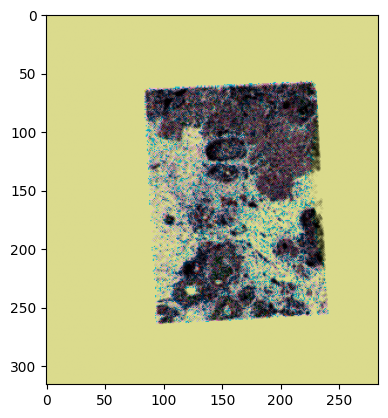

In [85]:
# we can double check the alignment against the neighborhood image against the first xenium section
rgb = vis_utils.display_labeled_as_rgb(nbhds[0])
plt.imshow(rgb)
plt.scatter(transformed_pts[:, 0], transformed_pts[:, 1], s=.001, c='black')

In [99]:
# to assign points, we need to index into the labeled neighborhoods for that section
transformed_pts = transformed_pts.astype(int) # need to be integers for indexing
labels = nbhds[0, transformed_pts[:, 1], transformed_pts[:, 0]] # get neighborhoods for points
adata.obs['xenium_nbhd_level1'] = [f'nbhd {label}' for label in labels] # set anndata metadata
len(labels), labels[:5]

(100346, array([11, 11, 14, 14, 14]))

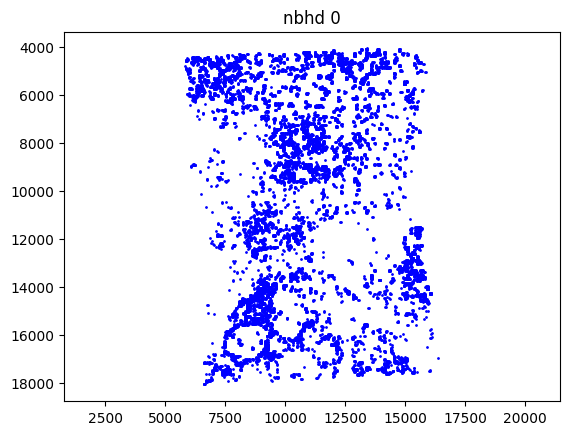

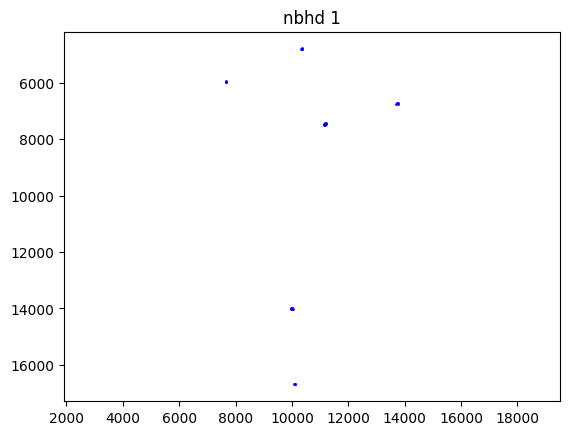

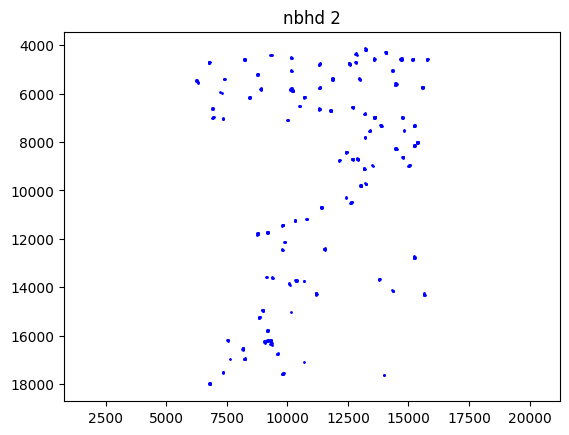

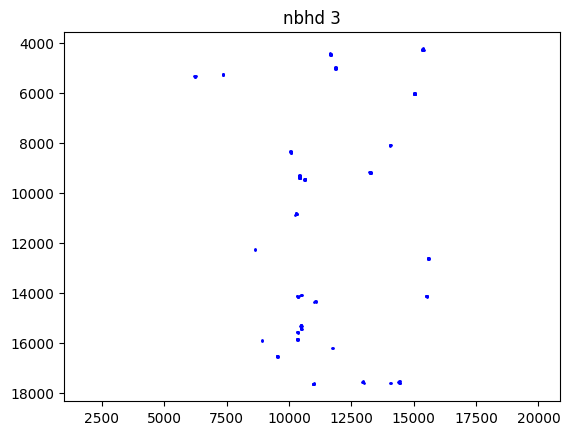

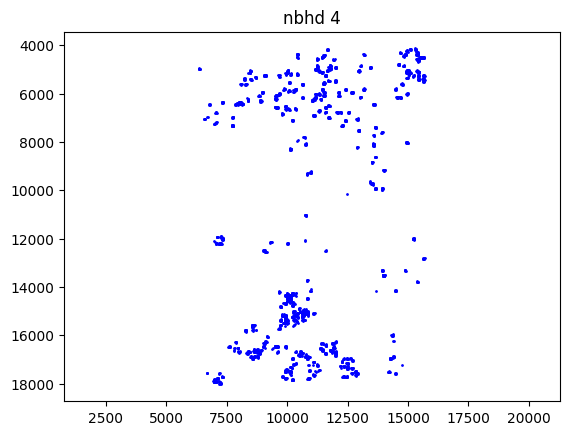

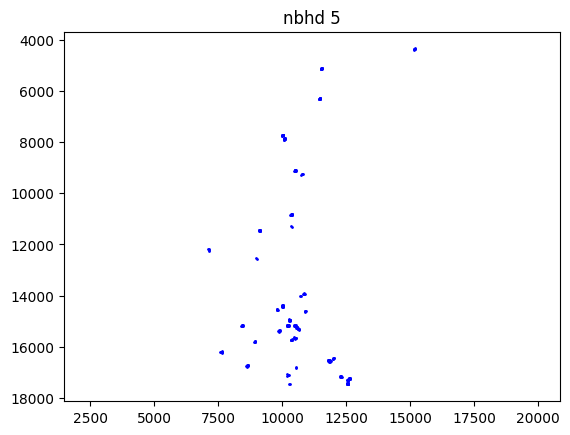

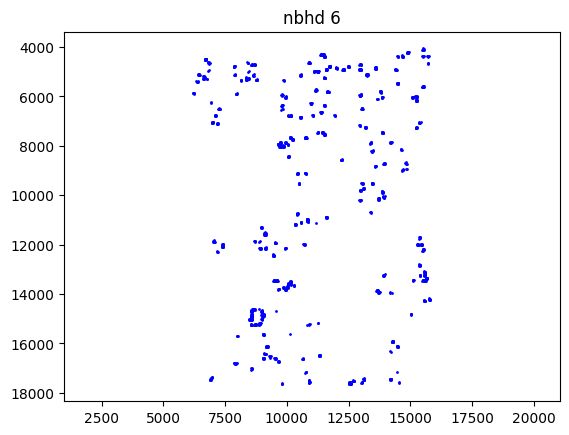

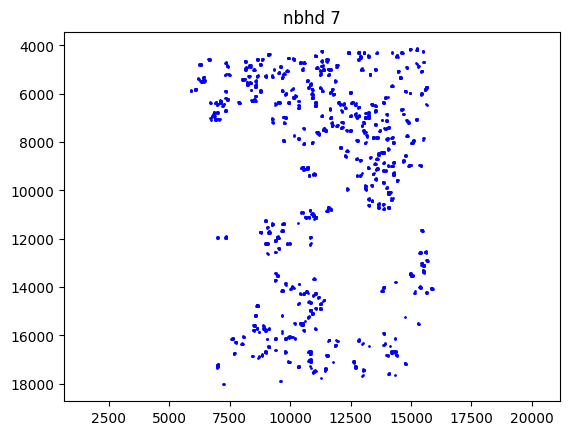

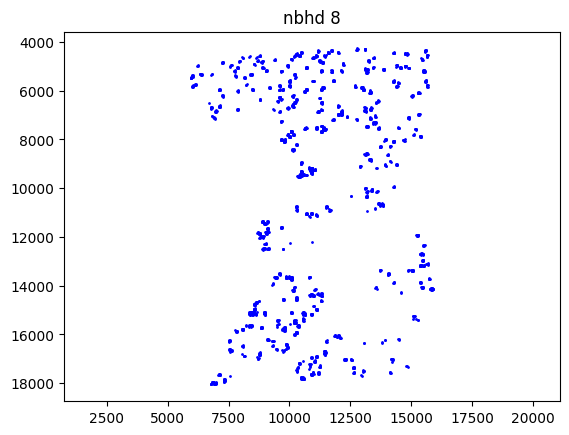

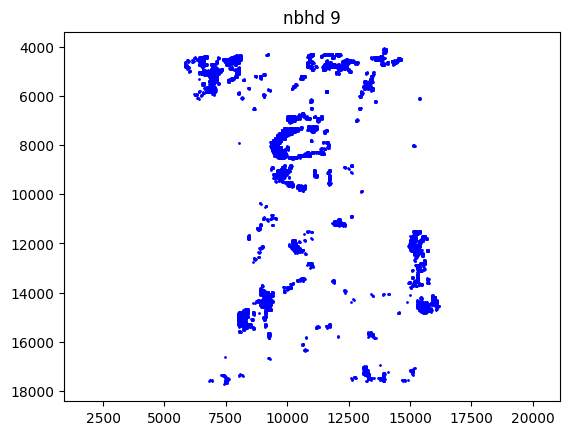

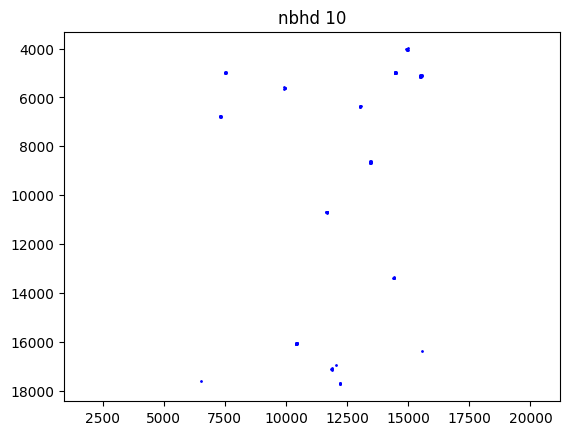

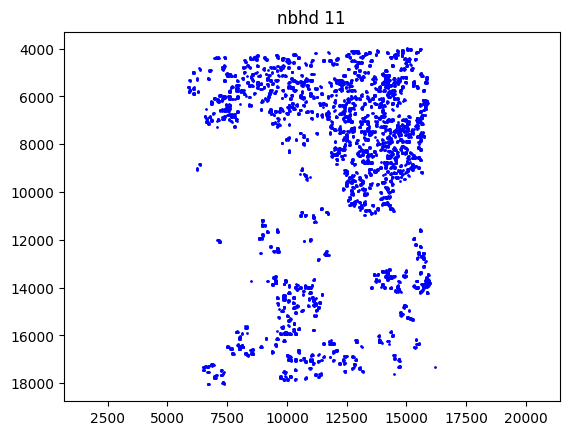

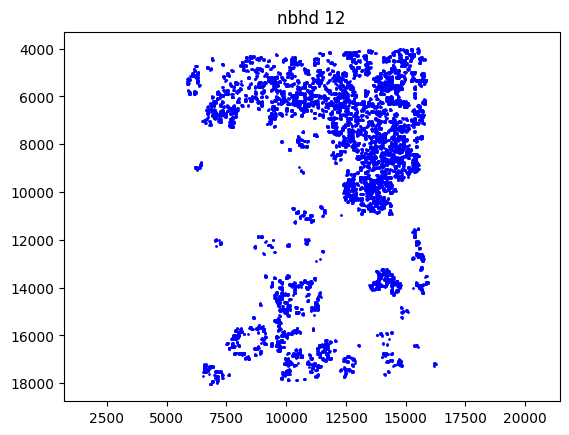

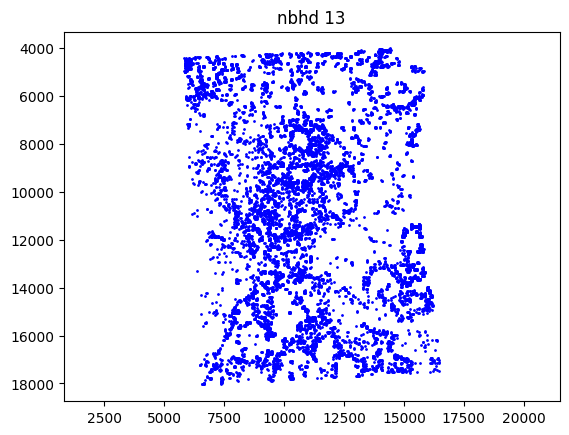

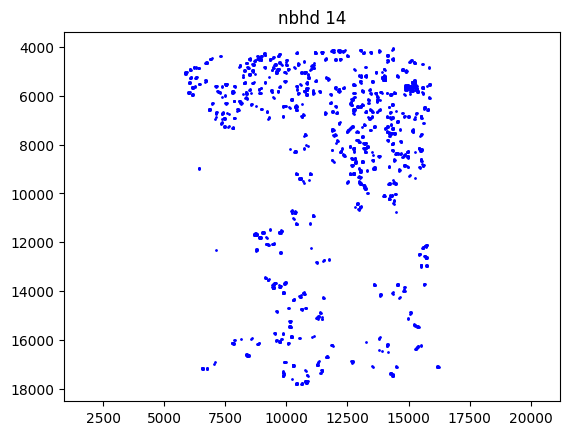

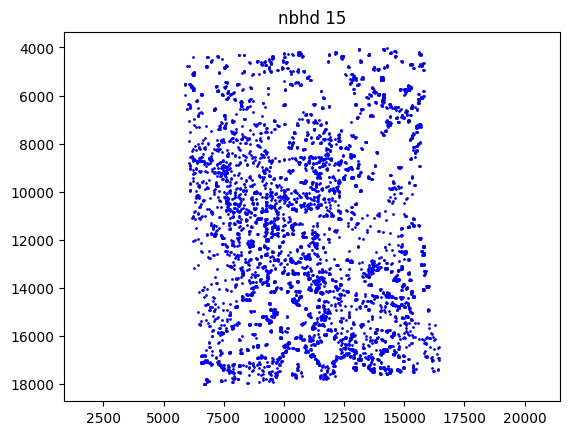

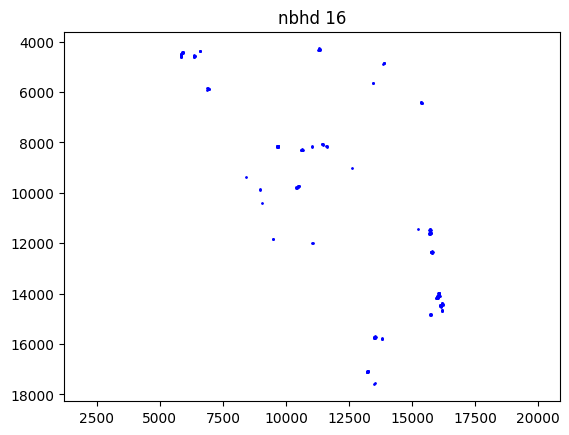

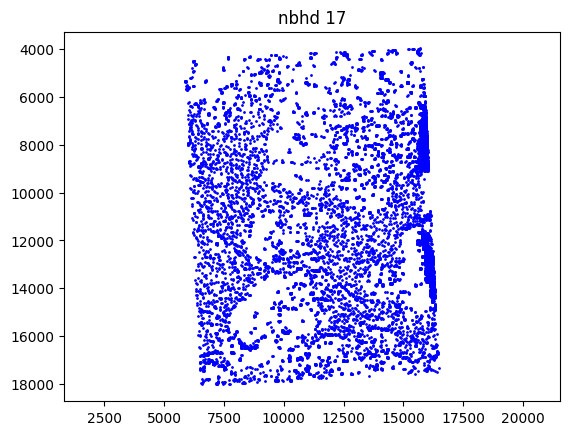

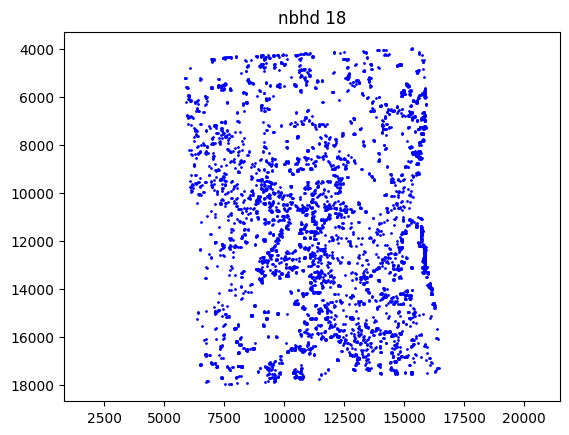

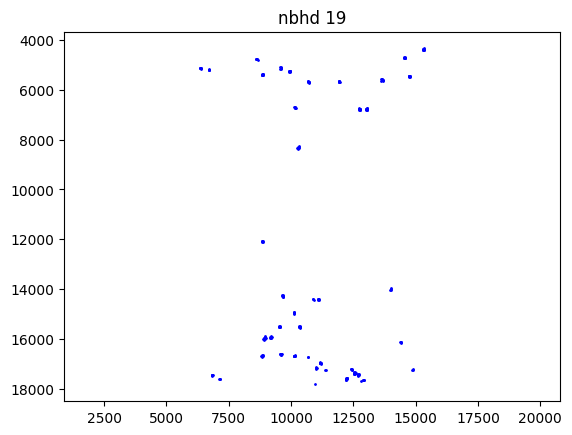

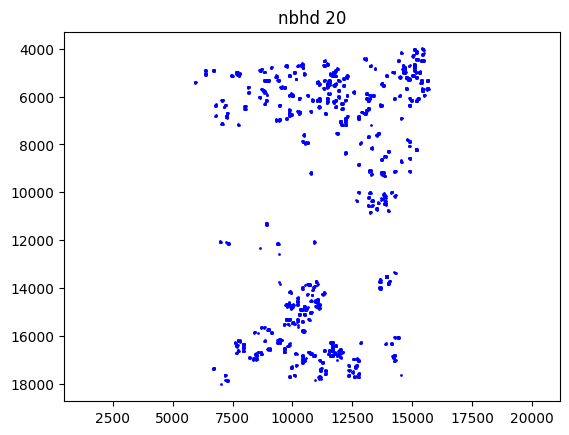

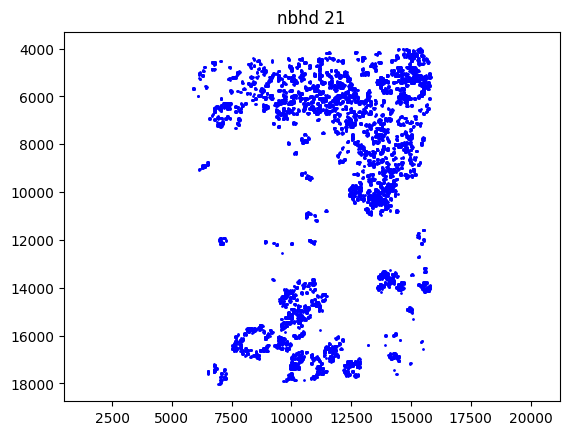

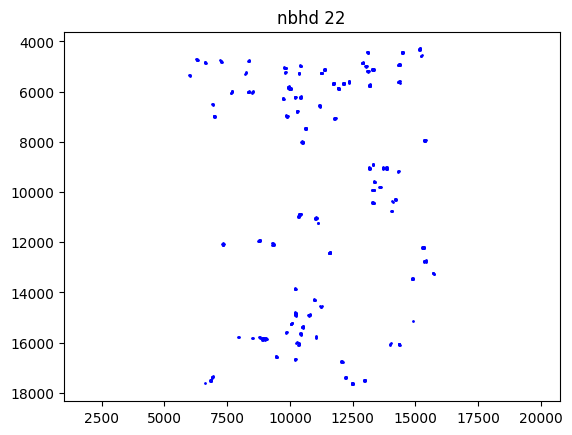

In [98]:
# and show them
for label in np.unique(nbhds[0]):
    filtered = pts[labels==label]
    plt.scatter(filtered[:, 0], filtered[:, 1], s=1., c='blue')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.title(f'nbhd {label}')
    plt.show()